In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/MyDrive/praktikum/praktikum4/data/stunting_wasting_dataset.csv"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

In [ ]:
df = pd.read_csv(path)
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [ ]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [ ]:
df.duplicated().sum() # buat cek data duplikat

np.int64(7308)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum() # buat apus data dupikat

np.int64(0)

In [ ]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [ ]:
# maping kolom stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('int64')

# maping kolom jenis kelamin -> biner
# laki2 = 1 perempuan = 0
df['JK_bin']= (df['Jenis Kelamin']=='Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    20372
Name: count, dtype: int64

Distribusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: int64


/tmp/ipython-input-114043030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('int64')
/tmp/ipython-input-114043030.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['JK_bin']= (df['Jenis Kelamin']=='Laki-laki').astype(int)


In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.037173,0.000636
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.288216,0.070159
Berat Badan (kg),0.659566,0.618453,1.000000,0.020676,0.043446
Stunting_bin,0.037173,-0.288216,0.020676,1.000000,-0.005187
JK_bin,0.000636,0.070159,0.043446,-0.005187,1.000000


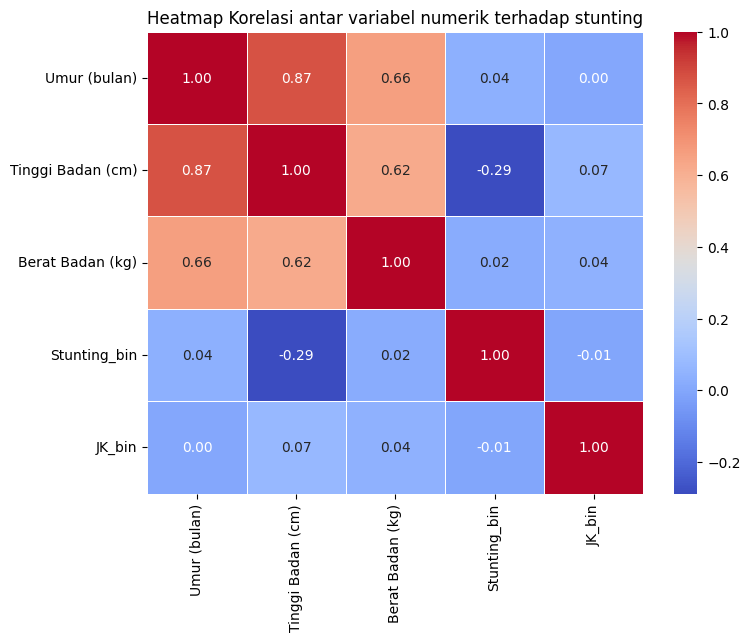

In [ ]:
# visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi antar variabel numerik terhadap stunting', fontsize=12)
plt.show()

In [ ]:
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (92692, 4)
y shape: (92692,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )
print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (74153, 4)
Data uji: (18539, 4)


In [1]:
praprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter = 1000,
    solver = 'lbfgs',
    class_weight = 'balanced',
    random_state=42
)

clf = Pipeline([
    ('praprocess', praprocess),
    ('model', model)
])

clf.fit(X_train, y_train)
print("model logistik berhasil dilatih")

NameError: name 'ColumnTransformer' is not defined

In [ ]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score

print(f"Akurasi        : {accuracy_score(y_test, y_pred):.4f}")
print(f"Presisi        : {precision_score(y_test, y_pred, zero_division=0):4f}")
print(f"Recall         : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score       : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC AUC Score  : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi        : 0.9063
Presisi        : 0.713893
Recall         : 0.9571
F1 Score       : 0.8178
ROC AUC Score  : 0.9651


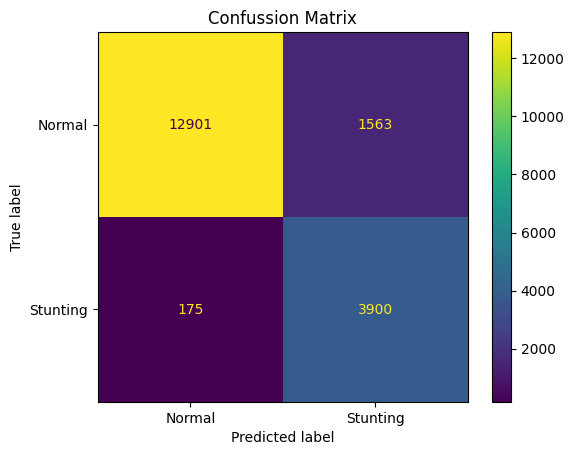

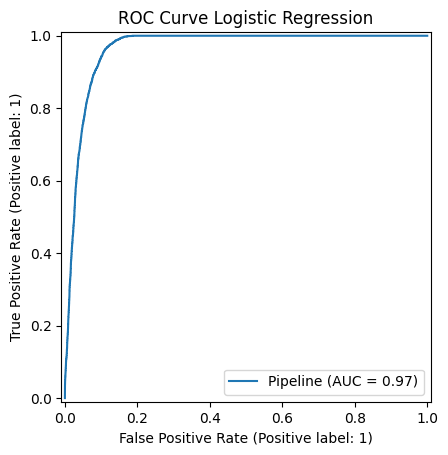

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['Normal', 'Stunting']
).plot(values_format='d')

plt.title("Confussion Matrix")
plt.show()

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.99      0.89      0.94     14464
      Stunting (1)       0.71      0.96      0.82      4075

          accuracy                           0.91     18539
         macro avg       0.85      0.92      0.88     18539
      weighted avg       0.93      0.91      0.91     18539



In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)

print("Skor tiap fold", scores)
print("Rata-rata akurasi", np.mean(scores))
print("Skor tiap fold", np.std(scores))

Skor tiap fold [0.9084093  0.90414801 0.90468227 0.90673212 0.9028482 ]
Rata-rata akurasi 0.9053639814725255
Skor tiap fold 0.001970695381359219


In [ ]:
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.661420,5775.733054
3,JK_bin,1.726339,5.620042
2,Berat Badan (kg),0.653153,1.921590
1,Tinggi Badan (cm),-10.742834,0.000022


In [ ]:
data_baru = pd.DataFrame({
    'Umur (bulan)': [24,10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = pred
hasil['Prob (0=Tidak, 1=Ya)'] = prob
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Prob (0=Tidak, 1=Ya)"
0,24,79.0,9.2,1,1,0.998346
1,10,72.5,7.8,0,0,0.001810
